## 0. Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split

## 1. Data Preparation & EDA (Exploratory Data Analysis)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define base directories and CSV paths
base_dir = '/content/drive/MyDrive/Colab Notebooks/artifact_detection_project'
data_dir = os.path.join(base_dir, 'trainee_dataset')
models_dir = os.path.join(base_dir, 'models')
csv_train = os.path.join(base_dir, 'train.csv')
csv_val = os.path.join(base_dir, 'val.csv')

# Create directories if they don't exist
os.makedirs(data_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

# Set paths to image folders
train_path = os.path.join(data_dir, 'train')
test_path = os.path.join(data_dir, 'test')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The file names already contain the class label, so I extracted it using a regular expression. The label is the last number before .png.

In [ ]:
# Get filenames and labels from the train folder
train_files = [f for f in os.listdir(train_path) if f.endswith('.png')]
train_df = pd.DataFrame(train_files, columns=['filename'])
train_df['label'] = train_df['filename'].str.extract(r'_(\d)\.png').astype(int)

print(f"Total TRAIN images: {len(train_df)}")
display(train_df.head())

Total TRAIN images: 1800


,filename,label
0,image_01474_1.png,1
1,image_00187_1.png,1
2,image_01601_1.png,1
3,image_00199_1.png,1
4,image_00906_1.png,1


I wanted to verify if the dataset is balanced. Turns out, it’s not — there are way more clean images than artifacted ones (about 9:1).

I decided not to fix this imbalance for now. But later, I could use: oversampling (for class 0), class weights during training, or loss functions like Focal Loss.

<ipython-input-8-6c32528bc318>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='label', palette='Set2')


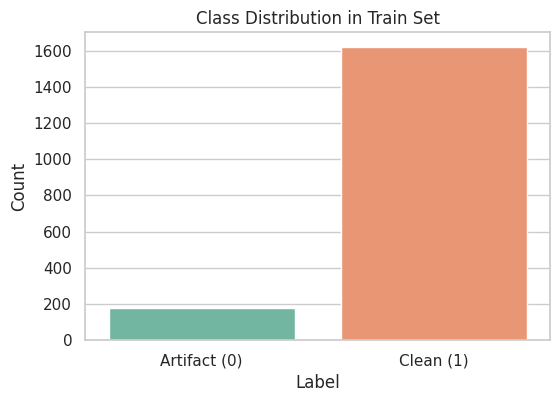

In [ ]:
# Plot class distribution
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x='label', palette='Set2')
plt.title('Class Distribution in Train Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Artifact (0)', 'Clean (1)'])
plt.show()

To get a better feel for the data, I visualized a few examples from each class. To be honest, I personally couldn’t always tell what’s “clean” or “artifacted”, so I’m curious to see what the model will learn (yes we can see differencies, but I still doubt couple of images and correctness of their label)

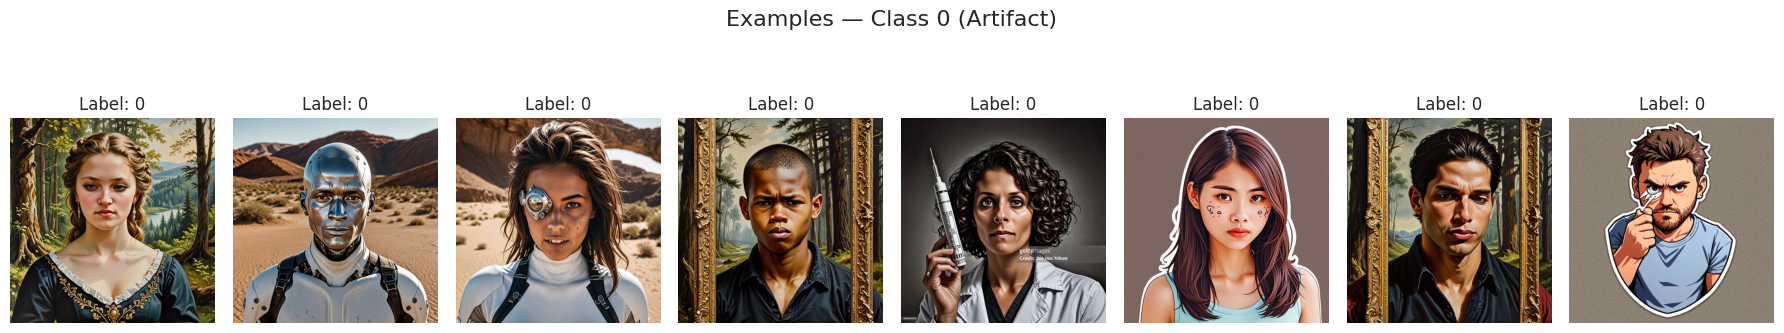

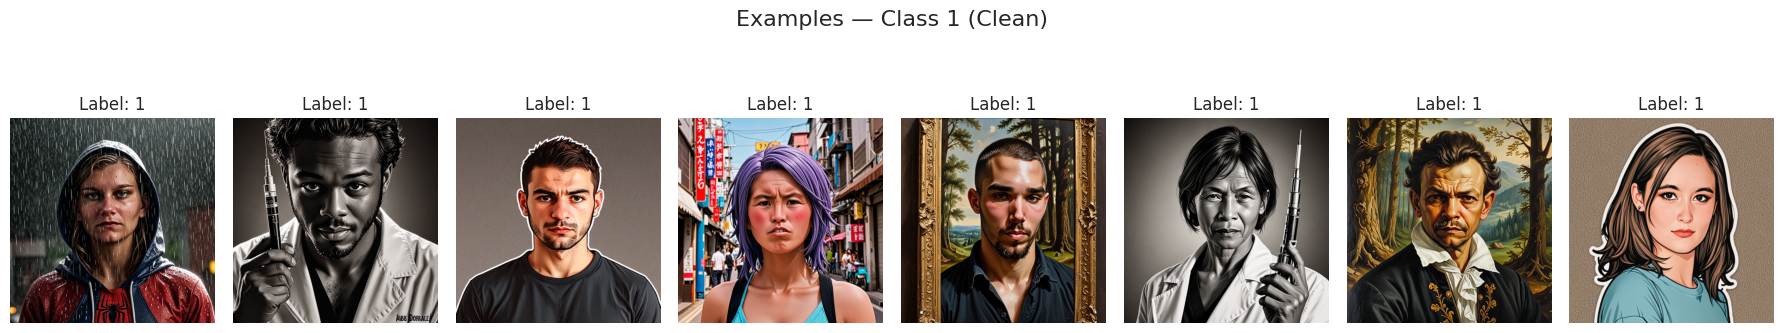

In [ ]:
# Show a few sample images per class
def show_class_samples(df, image_dir, label, n=8):
    samples = df[df['label'] == label].sample(n, random_state=42)
    plt.figure(figsize=(18, 4))
    for i, filename in enumerate(samples['filename']):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)[..., ::-1]
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.suptitle(f"Examples — Class {label} ({'Artifact' if label == 0 else 'Clean'})", fontsize=16)
    plt.tight_layout()
    plt.show()

# Show samples for both classes
show_class_samples(train_df, train_path, label=0)
show_class_samples(train_df, train_path, label=1)

Before resizing or feeding images into a model, I need to ensure they’re consistent in size. I scanned all images to check their dimensions.

Most images had the same shape, which is great — this means I can safely resize them to a fixed dimension without major preprocessing.

In [ ]:
from tqdm import tqdm

shapes = []

for file in tqdm(train_files, desc="Reading images"):
    img = cv2.imread(os.path.join(train_path, file))
    if img is not None:
        shapes.append(img.shape)

shape_counts = Counter(shapes).most_common()

print("Most common image shapes:")
for shape, count in shape_counts:
    print(f"{shape}: {count}")

Reading images: 100%|██████████| 1800/1800 [04:39<00:00,  6.44it/s]

Most common image shapes:
(1024, 1024, 3): 1800


Although I was given only a train and test split, I strongly believe (thanks to Andrew Ng's Machine Learning Yearning) that I should reserve a validation set for:

- tuning model hyperparameters;
- monitoring overfitting during training.

So, I split 20% of the train set into a validation set using stratified sampling to preserve label balance.

In [ ]:
# Split and save CSVs
train_split_df, val_split_df = train_test_split(
    train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

print(f"Train set size: {len(train_split_df)} | Validation set size: {len(val_split_df)}")

train_split_df.to_csv(csv_train, index=False)
val_split_df.to_csv(csv_val, index=False)

Train set size: 1440 | Validation set size: 360


## 2. Dataset & DataLoader Setup

In [ ]:
!pip install timm albumentations --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm
from sklearn.metrics import f1_score

To train a model in PyTorch, I needed a custom Dataset class. I created ArtifactDataset, which takes a DataFrame, image folder path, and image transforms as input.

Each image is:

- read using OpenCV;
- converted from BGR to RGB;
- optionally transformed using Albumentations (for data augmentation and preprocessing).

In [ ]:
class ArtifactDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_path = os.path.join(self.image_dir, row['filename'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, torch.tensor(row['label'], dtype=torch.float32)

I chose Albumentations because it's fast, flexible, and has strong support for PyTorch (ToTensorV2). It's also widely used in CV competitions.

I defined two sets of transforms:

1. Train transforms: include resizing, flipping, contrast/brightness change, rotation/shift, and normalization — all useful for improving generalization.
2. Validation transforms: only resize and normalize — no augmentation here to keep validation fair and deterministic.

Then, I loaded my train.csv and val.csv (from Step 1), and wrapped them using PyTorch's DataLoader to efficiently batch, shuffle, and load data.

In [ ]:
# Transforms
train_tfms = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(p=0.4),
    A.Normalize(),
    ToTensorV2(),
])
val_tfms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2(),
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


## 3. Train multiple CNN models (EffNet, ResNet, ConvNeXt)

Previously, I mostly used Keras (with TensorFlow backend) for deep learning projects. This time, I specifically wanted to try PyTorch

Here I trained three different CNN architectures to classify the images:

1. EfficientNet-B0
2. ResNet-50
3. ConvNeXt-Tiny

All of them were loaded via the timm library with pretrained ImageNet weights. I replaced the final classification layer with a single output node for binary classification

In [ ]:
# Load data
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/artifact_detection_project/train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/artifact_detection_project/val.csv')
image_dir = '/content/drive/MyDrive/Colab Notebooks/artifact_detection_project/trainee_dataset/train'

train_loader = DataLoader(ArtifactDataset(train_df, image_dir, train_tfms), batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(ArtifactDataset(val_df, image_dir, val_tfms), batch_size=32, shuffle=False, num_workers=2)

I wrote reusable training and validation functions:

- train_one_epoch: trains the model on one epoch;
- validate: evaluates performance using micro F1 score (required by the task);
- train_and_save_model: combines training logic with early stopping and model saving.

I used:

- BCEWithLogitsLoss (binary cross-entropy with logits);
- Adam optimizer;
- Early stopping (with patience) to avoid overfitting and reduce wasted compute;
- Micro F1 Score to measure accuracy across both classes, which is helpful given the class imbalance.

In [ ]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        loss = criterion(model(images), labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [ ]:
def validate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            preds = (torch.sigmoid(outputs).cpu().numpy() > 0.5).astype(int)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds)
    return val_loss / len(dataloader), f1_score(y_true, y_pred, average='micro')

To avoid overfitting or wasting compute, I added an early stopping mechanism:

1. It tracks the best validation loss across epochs.
2. If the model doesn’t improve after patience epochs, training stops.
3. When training finishes, I restore the model to its best weights.

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.best_state = None

    def step(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_state = model.state_dict()
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

    def restore_best_weights(self, model):
        model.load_state_dict(self.best_state)

In [ ]:
def train_and_save_model(model, model_name, save_path, num_epochs=20, patience=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()

    early_stopping = EarlyStopping(patience=patience)
    history = {'train_loss': [], 'val_loss': [], 'val_f1': []}

    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch} ({model_name})")
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_f1 = validate(model, val_loader, criterion, device)

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Micro F1: {val_f1:.4f}")
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)

        if early_stopping.step(val_loss, model):
            print(f"No improvement for {patience} epochs. Early stopping.")
            break

    # Save best weights after training
    early_stopping.restore_best_weights(model)
    torch.save(model.state_dict(), save_path)
    print(f"Final model saved to {save_path}")

    return model, history

I use this helper function to visualize:
- how training loss and validation loss changed across epochs;
- if the model was overfitting, underfitting, or converging well.
- this gives me quick insight into model behavior during training.

In [ ]:
def plot_training_curves(history, model_name):
    plt.figure(figsize=(10, 4))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f"{model_name} Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# EfficientNet
class EfficientNetClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True)
        in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.backbone(x)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]


Epoch 1 (EfficientNet)


100%|██████████| 45/45 [01:57<00:00,  2.60s/it]


Train Loss: 0.4479 | Val Loss: 0.2545 | Micro F1: 0.9000

Epoch 2 (EfficientNet)


100%|██████████| 45/45 [01:04<00:00,  1.43s/it]


Train Loss: 0.2199 | Val Loss: 0.2165 | Micro F1: 0.9194

Epoch 3 (EfficientNet)


100%|██████████| 45/45 [01:02<00:00,  1.39s/it]


Train Loss: 0.1493 | Val Loss: 0.1866 | Micro F1: 0.9444

Epoch 4 (EfficientNet)


100%|██████████| 45/45 [01:05<00:00,  1.46s/it]


Train Loss: 0.1066 | Val Loss: 0.1767 | Micro F1: 0.9389

Epoch 5 (EfficientNet)


100%|██████████| 45/45 [01:05<00:00,  1.47s/it]


Train Loss: 0.0614 | Val Loss: 0.1610 | Micro F1: 0.9472

Epoch 6 (EfficientNet)


100%|██████████| 45/45 [01:05<00:00,  1.45s/it]


Train Loss: 0.0583 | Val Loss: 0.1646 | Micro F1: 0.9500

Epoch 7 (EfficientNet)


100%|██████████| 45/45 [01:03<00:00,  1.42s/it]


Train Loss: 0.0386 | Val Loss: 0.1594 | Micro F1: 0.9528

Epoch 8 (EfficientNet)


100%|██████████| 45/45 [01:05<00:00,  1.46s/it]


Train Loss: 0.0268 | Val Loss: 0.1581 | Micro F1: 0.9583

Epoch 9 (EfficientNet)


100%|██████████| 45/45 [01:05<00:00,  1.45s/it]


Train Loss: 0.0296 | Val Loss: 0.1617 | Micro F1: 0.9556

Epoch 10 (EfficientNet)


100%|██████████| 45/45 [01:03<00:00,  1.41s/it]


Train Loss: 0.0301 | Val Loss: 0.1928 | Micro F1: 0.9583

Epoch 11 (EfficientNet)


100%|██████████| 45/45 [01:04<00:00,  1.43s/it]


Train Loss: 0.0276 | Val Loss: 0.1541 | Micro F1: 0.9583

Epoch 12 (EfficientNet)


100%|██████████| 45/45 [01:04<00:00,  1.44s/it]


Train Loss: 0.0326 | Val Loss: 0.1849 | Micro F1: 0.9528

Epoch 13 (EfficientNet)


100%|██████████| 45/45 [01:03<00:00,  1.41s/it]


Train Loss: 0.0253 | Val Loss: 0.1859 | Micro F1: 0.9556

Epoch 14 (EfficientNet)


100%|██████████| 45/45 [01:04<00:00,  1.42s/it]


Train Loss: 0.0228 | Val Loss: 0.1647 | Micro F1: 0.9583

Epoch 15 (EfficientNet)


100%|██████████| 45/45 [01:05<00:00,  1.46s/it]


Train Loss: 0.0142 | Val Loss: 0.1842 | Micro F1: 0.9583

Epoch 16 (EfficientNet)


100%|██████████| 45/45 [01:04<00:00,  1.42s/it]


Train Loss: 0.0183 | Val Loss: 0.1904 | Micro F1: 0.9556
No improvement for 5 epochs. Early stopping.
Final model saved to effnet_b0_best.pth


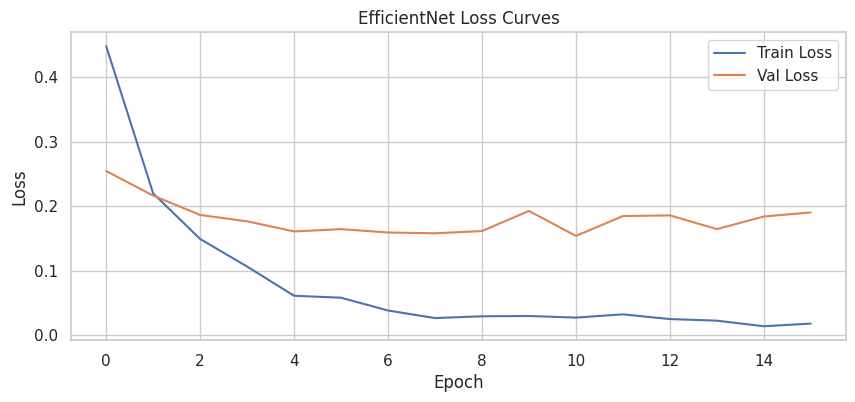

In [ ]:
model, history = train_and_save_model(EfficientNetClassifier(), "EfficientNet", "effnet_b0_best.pth")
plot_training_curves(history, "EfficientNet")

In [ ]:
# ResNet
class ResNetClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model('resnet50', pretrained=True)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.backbone(x)

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]


Epoch 1 (ResNet)


100%|██████████| 45/45 [01:04<00:00,  1.44s/it]


Train Loss: 0.5457 | Val Loss: 0.3980 | Micro F1: 0.9000

Epoch 2 (ResNet)


100%|██████████| 45/45 [01:05<00:00,  1.45s/it]


Train Loss: 0.3461 | Val Loss: 0.2783 | Micro F1: 0.9000

Epoch 3 (ResNet)


100%|██████████| 45/45 [01:06<00:00,  1.48s/it]


Train Loss: 0.2682 | Val Loss: 0.2464 | Micro F1: 0.9000

Epoch 4 (ResNet)


100%|██████████| 45/45 [01:08<00:00,  1.51s/it]


Train Loss: 0.2351 | Val Loss: 0.2276 | Micro F1: 0.9000

Epoch 5 (ResNet)


100%|██████████| 45/45 [01:07<00:00,  1.50s/it]


Train Loss: 0.2069 | Val Loss: 0.2175 | Micro F1: 0.9000

Epoch 6 (ResNet)


100%|██████████| 45/45 [01:22<00:00,  1.84s/it]


Train Loss: 0.1824 | Val Loss: 0.2063 | Micro F1: 0.9056

Epoch 7 (ResNet)


100%|██████████| 45/45 [01:09<00:00,  1.55s/it]


Train Loss: 0.1670 | Val Loss: 0.1971 | Micro F1: 0.9167

Epoch 8 (ResNet)


100%|██████████| 45/45 [01:14<00:00,  1.66s/it]


Train Loss: 0.1509 | Val Loss: 0.1919 | Micro F1: 0.9306

Epoch 9 (ResNet)


100%|██████████| 45/45 [01:05<00:00,  1.46s/it]


Train Loss: 0.1281 | Val Loss: 0.1853 | Micro F1: 0.9333

Epoch 10 (ResNet)


100%|██████████| 45/45 [01:03<00:00,  1.42s/it]


Train Loss: 0.1091 | Val Loss: 0.1742 | Micro F1: 0.9444

Epoch 11 (ResNet)


100%|██████████| 45/45 [01:06<00:00,  1.47s/it]


Train Loss: 0.0950 | Val Loss: 0.1633 | Micro F1: 0.9444

Epoch 12 (ResNet)


100%|██████████| 45/45 [01:05<00:00,  1.45s/it]


Train Loss: 0.0875 | Val Loss: 0.1551 | Micro F1: 0.9528

Epoch 13 (ResNet)


100%|██████████| 45/45 [01:04<00:00,  1.43s/it]


Train Loss: 0.0662 | Val Loss: 0.1583 | Micro F1: 0.9556

Epoch 14 (ResNet)


100%|██████████| 45/45 [01:03<00:00,  1.42s/it]


Train Loss: 0.0590 | Val Loss: 0.1561 | Micro F1: 0.9583

Epoch 15 (ResNet)


100%|██████████| 45/45 [01:05<00:00,  1.45s/it]


Train Loss: 0.0561 | Val Loss: 0.1581 | Micro F1: 0.9556

Epoch 16 (ResNet)


100%|██████████| 45/45 [01:05<00:00,  1.45s/it]


Train Loss: 0.0517 | Val Loss: 0.1655 | Micro F1: 0.9583

Epoch 17 (ResNet)


100%|██████████| 45/45 [01:03<00:00,  1.41s/it]


Train Loss: 0.0506 | Val Loss: 0.1838 | Micro F1: 0.9556
No improvement for 5 epochs. Early stopping.
Final model saved to resnet50_best.pth


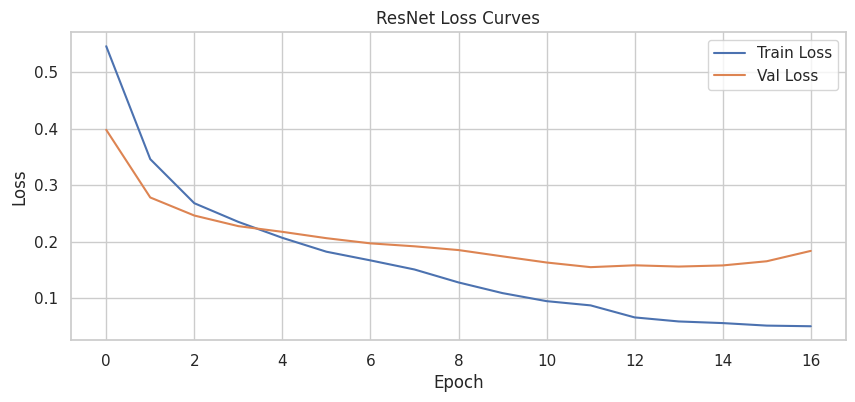

In [ ]:
model, history = train_and_save_model(ResNetClassifier(), "ResNet", "resnet50_best.pth")
plot_training_curves(history, "ResNet")

In [ ]:
# ConvNeXt
class ConvNeXtClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model('convnext_tiny', pretrained=True, num_classes=1)

    def forward(self, x):
        return self.backbone(x)

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]


Epoch 1 (ConvNeXt)


100%|██████████| 45/45 [01:12<00:00,  1.60s/it]


Train Loss: 0.3425 | Val Loss: 0.2267 | Micro F1: 0.9222

Epoch 2 (ConvNeXt)


100%|██████████| 45/45 [01:12<00:00,  1.60s/it]


Train Loss: 0.1863 | Val Loss: 0.1554 | Micro F1: 0.9556

Epoch 3 (ConvNeXt)


100%|██████████| 45/45 [01:12<00:00,  1.62s/it]


Train Loss: 0.1435 | Val Loss: 0.1325 | Micro F1: 0.9611

Epoch 4 (ConvNeXt)


100%|██████████| 45/45 [01:13<00:00,  1.62s/it]


Train Loss: 0.1210 | Val Loss: 0.1418 | Micro F1: 0.9528

Epoch 5 (ConvNeXt)


100%|██████████| 45/45 [01:11<00:00,  1.59s/it]


Train Loss: 0.1265 | Val Loss: 0.1738 | Micro F1: 0.9556

Epoch 6 (ConvNeXt)


100%|██████████| 45/45 [01:11<00:00,  1.60s/it]


Train Loss: 0.1128 | Val Loss: 0.1521 | Micro F1: 0.9556

Epoch 7 (ConvNeXt)


100%|██████████| 45/45 [01:12<00:00,  1.61s/it]


Train Loss: 0.0922 | Val Loss: 0.1765 | Micro F1: 0.9639

Epoch 8 (ConvNeXt)


100%|██████████| 45/45 [01:12<00:00,  1.61s/it]


Train Loss: 0.0834 | Val Loss: 0.1304 | Micro F1: 0.9667

Epoch 9 (ConvNeXt)


100%|██████████| 45/45 [01:12<00:00,  1.61s/it]


Train Loss: 0.0954 | Val Loss: 0.1593 | Micro F1: 0.9667

Epoch 10 (ConvNeXt)


100%|██████████| 45/45 [01:12<00:00,  1.60s/it]


Train Loss: 0.0884 | Val Loss: 0.1604 | Micro F1: 0.9444

Epoch 11 (ConvNeXt)


100%|██████████| 45/45 [01:11<00:00,  1.58s/it]


Train Loss: 0.0625 | Val Loss: 0.1475 | Micro F1: 0.9639

Epoch 12 (ConvNeXt)


100%|██████████| 45/45 [01:10<00:00,  1.56s/it]


Train Loss: 0.0555 | Val Loss: 0.1439 | Micro F1: 0.9639

Epoch 13 (ConvNeXt)


100%|██████████| 45/45 [01:10<00:00,  1.56s/it]


Train Loss: 0.0578 | Val Loss: 0.2002 | Micro F1: 0.9556
No improvement for 5 epochs. Early stopping.
Final model saved to convnext_tiny_best.pth


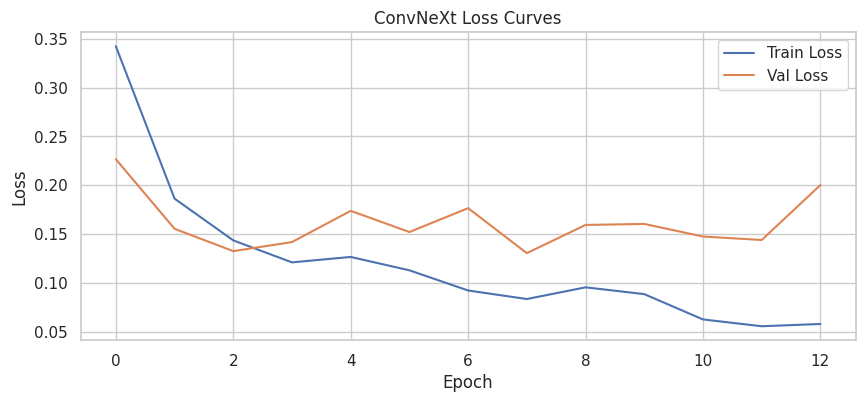

In [ ]:
model, history = train_and_save_model(ConvNeXtClassifier(), "ConvNeXt", "convnext_tiny_best.pth")
plot_training_curves(history, "ConvNeXt")

I also moved the models to my Google Drive so I don’t lose them.

In [ ]:
import shutil

# Move trained model files to Drive
models_dir = "/content/drive/MyDrive/Colab Notebooks/artifact_detection_project/models"
shutil.move("/content/effnet_b0_best.pth", os.path.join(models_dir, "effnet_b0_best.pth"))
shutil.move("/content/resnet50_best.pth", os.path.join(models_dir, "resnet50_best.pth"))
shutil.move("/content/convnext_tiny_best.pth", os.path.join(models_dir, "convnext_tiny_best.pth"))

'/content/drive/MyDrive/Colab Notebooks/artifact_detection_project/models/convnext_tiny_best.pth'

### Model Training Insights

#### EfficientNet-B0

1. The model improved quickly and reached a high micro F1 score early in training.
2. Validation loss decreased fast in the beginning but started to fluctuate slightly after several epochs.
3. The model was efficient in terms of training time per epoch and achieved good results without long training.

However, it showed signs of plateauing early, which suggests it might have learned everything it could from the current data without additional tricks like augmentations or label cleaning. Overall, a fast and effective model, but potentially limited in capturing more subtle artifacts in later stages.

#### ResNet-50

1. The model had a slow start; performance metrics stayed flat during the first few epochs.
2. After several epochs, both validation loss and F1 started improving steadily.
3. The training process was stable and consistent, with no overfitting observed early on.

It required more time to train compared to EfficientNet but continued to improve until the final epochs. This model is dependable and generalizes well, but it's slower to converge and may not be ideal if training time is limited.

#### ConvNeXt-Tiny

1. ConvNeXt started strong and quickly reached a high micro F1 score within the first few epochs.
2. Both training and validation losses went down smoothly. Even when they moved slightly up or down, the model stayed accurate.
3. The model handled the task well and seemed to learn deep and robust features from the images.

While training time per epoch was slightly longer than EfficientNet, the improvements in performance made up for it. Among the three models, ConvNeXt achieved the best overall validation performance in the fewest epochs.

## 4. Try alternative methods (Autoencoder, CLIP)

After training standard CNN classifiers (EfficientNet, ResNet, ConvNeXt), I wanted to try something different — methods that don’t rely purely on supervised learning with cross-entropy classification.

I noticed that most images are clean (class 1), and artifacts are the minority. This makes it similar to an anomaly detection problem — where we learn what “normal” looks like, and detect anything that doesn’t match it well. Autoencoders are often used in these situations.

So:
1. I trained an autoencoder to reconstruct clean images.
2. At validation time, I compare the original image with the reconstruction.
3. If the reconstruction error is high, the image might contain an artifact.

The idea is that the model won’t be able to accurately reconstruct images with unusual features (like distorted hands or broken eyes), since it mostly learned from artifact-free ones.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # [B, 32, 112, 112]
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # [B, 64, 56, 56]
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # [B, 128, 28, 28]
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # [B, 64, 56, 56]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # [B, 32, 112, 112]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),  # [B, 3, 224, 224]
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
def train_autoencoder(model, train_loader, val_loader, save_path, num_epochs=40, patience=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()

    early_stopping = EarlyStopping(patience=patience)
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch} (Autoencoder)")

        # Training phase
        model.train()
        total_train_loss = 0
        for images, _ in tqdm(train_loader):
            images = images.to(device)
            optimizer.zero_grad()
            recon = model(images)
            loss = criterion(recon, images)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        train_loss = total_train_loss / len(train_loader)

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)
                recon = model(images)
                loss = criterion(recon, images)
                total_val_loss += loss.item()
        val_loss = total_val_loss / len(val_loader)

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        if early_stopping.step(val_loss, model):
            print(f"No improvement for {patience} epochs. Early stopping.")
            break

    # Restore and save best model
    early_stopping.restore_best_weights(model)
    torch.save(model.state_dict(), save_path)
    print(f"Final best autoencoder model saved to {save_path}")

    return model, history


Epoch 1 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.24s/it]


Train Loss: 1.9361 | Val Loss: 1.3610

Epoch 2 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


Train Loss: 1.4826 | Val Loss: 1.3211

Epoch 3 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


Train Loss: 1.4543 | Val Loss: 1.2746

Epoch 4 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


Train Loss: 1.3955 | Val Loss: 1.2351

Epoch 5 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.24s/it]


Train Loss: 1.3630 | Val Loss: 1.2103

Epoch 6 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.24s/it]


Train Loss: 1.3417 | Val Loss: 1.1898

Epoch 7 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


Train Loss: 1.3264 | Val Loss: 1.1769

Epoch 8 (Autoencoder)


100%|██████████| 45/45 [00:54<00:00,  1.21s/it]


Train Loss: 1.3185 | Val Loss: 1.1691

Epoch 9 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


Train Loss: 1.3087 | Val Loss: 1.1633

Epoch 10 (Autoencoder)


100%|██████████| 45/45 [00:56<00:00,  1.25s/it]


Train Loss: 1.3106 | Val Loss: 1.1586

Epoch 11 (Autoencoder)


100%|██████████| 45/45 [00:54<00:00,  1.22s/it]


Train Loss: 1.3035 | Val Loss: 1.1546

Epoch 12 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


Train Loss: 1.2966 | Val Loss: 1.1513

Epoch 13 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


Train Loss: 1.2961 | Val Loss: 1.1482

Epoch 14 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


Train Loss: 1.2846 | Val Loss: 1.1454

Epoch 15 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.22s/it]


Train Loss: 1.2906 | Val Loss: 1.1431

Epoch 16 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


Train Loss: 1.2875 | Val Loss: 1.1404

Epoch 17 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


Train Loss: 1.2895 | Val Loss: 1.1381

Epoch 18 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


Train Loss: 1.2765 | Val Loss: 1.1357

Epoch 19 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


Train Loss: 1.2854 | Val Loss: 1.1336

Epoch 20 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.24s/it]


Train Loss: 1.2790 | Val Loss: 1.1317

Epoch 21 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


Train Loss: 1.2774 | Val Loss: 1.1299

Epoch 22 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.24s/it]


Train Loss: 1.2785 | Val Loss: 1.1283

Epoch 23 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


Train Loss: 1.2689 | Val Loss: 1.1268

Epoch 24 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


Train Loss: 1.2763 | Val Loss: 1.1254

Epoch 25 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


Train Loss: 1.2766 | Val Loss: 1.1245

Epoch 26 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


Train Loss: 1.2666 | Val Loss: 1.1230

Epoch 27 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


Train Loss: 1.2741 | Val Loss: 1.1220

Epoch 28 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


Train Loss: 1.2768 | Val Loss: 1.1211

Epoch 29 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.22s/it]


Train Loss: 1.2750 | Val Loss: 1.1207

Epoch 30 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


Train Loss: 1.2734 | Val Loss: 1.1197

Epoch 31 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


Train Loss: 1.2667 | Val Loss: 1.1186

Epoch 32 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


Train Loss: 1.2668 | Val Loss: 1.1180

Epoch 33 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.24s/it]


Train Loss: 1.2670 | Val Loss: 1.1172

Epoch 34 (Autoencoder)


100%|██████████| 45/45 [00:56<00:00,  1.25s/it]


Train Loss: 1.2675 | Val Loss: 1.1167

Epoch 35 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.22s/it]


Train Loss: 1.2743 | Val Loss: 1.1159

Epoch 36 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


Train Loss: 1.2618 | Val Loss: 1.1153

Epoch 37 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.23s/it]


Train Loss: 1.2586 | Val Loss: 1.1145

Epoch 38 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.24s/it]


Train Loss: 1.2609 | Val Loss: 1.1142

Epoch 39 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.24s/it]


Train Loss: 1.2627 | Val Loss: 1.1137

Epoch 40 (Autoencoder)


100%|██████████| 45/45 [00:55<00:00,  1.24s/it]


Train Loss: 1.2558 | Val Loss: 1.1128
Final best autoencoder model saved to /content/drive/MyDrive/Colab Notebooks/artifact_detection_project/models/autoencoder_best.pth


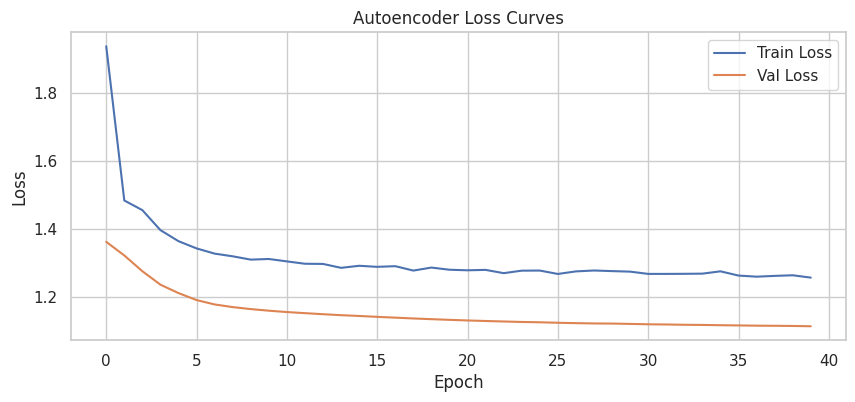

In [ ]:
autoencoder = Autoencoder()
autoencoder_path = os.path.join(models_dir, 'autoencoder_best.pth')
autoencoder, ae_history = train_autoencoder(autoencoder, train_loader, val_loader, autoencoder_path)
plot_training_curves(ae_history, "Autoencoder")

CLIP is a strong vision-language model pretrained on a huge dataset. It understands image content at a high level. My idea was to use CLIP’s image encoder to extract rich features, and then train a simple classifier (just one linear layer) on top.

How it works:
1. I didn’t fine-tune CLIP itself — only trained a small linear classifier on top of its image embeddings.
2. This keeps training fast and avoids overfitting, since CLIP’s features are already very good.

In [ ]:
!pip install ftfy regex tqdm --quiet
!pip install git+https://github.com/openai/CLIP.git --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import clip
from PIL import Image
from torchvision import transforms

In [ ]:
# Define CLIP transforms to match OpenAI's expected input
clip_preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.48145466, 0.4578275, 0.40821073),
        std=(0.26862954, 0.26130258, 0.27577711)
    ),
])

In [ ]:
# Dataset class for CLIP
class CLIPDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_path = os.path.join(self.image_dir, row['filename'])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(row['label'], dtype=torch.float32)

In [ ]:
# Load CLIP model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
clip_model, _ = clip.load("ViT-B/32", device=device)

# Freeze CLIP
for param in clip_model.parameters():
    param.requires_grad = False

100%|███████████████████████████████████████| 338M/338M [00:14<00:00, 24.6MiB/s]


In [ ]:
# Define the wrapper classifier
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.clip_model = clip_model
        self.linear = nn.Linear(self.clip_model.visual.output_dim, 1)

    def forward(self, x):
        with torch.no_grad():
            features = self.clip_model.encode_image(x)
        features = features.float()
        return self.linear(features)

In [ ]:
clip_train_loader = DataLoader(CLIPDataset(train_df, image_dir, clip_preprocess), batch_size=32, shuffle=True, num_workers=2)
clip_val_loader = DataLoader(CLIPDataset(val_df, image_dir, clip_preprocess), batch_size=32, shuffle=False, num_workers=2)


Epoch 1 (CLIPClassifier)


100%|██████████| 45/45 [01:20<00:00,  1.79s/it]


Train Loss: 0.5970 | Val Loss: 0.5460 | Micro F1: 0.8722

Epoch 2 (CLIPClassifier)


100%|██████████| 45/45 [01:03<00:00,  1.42s/it]


Train Loss: 0.5042 | Val Loss: 0.4701 | Micro F1: 0.9000

Epoch 3 (CLIPClassifier)


100%|██████████| 45/45 [01:00<00:00,  1.36s/it]


Train Loss: 0.4402 | Val Loss: 0.4181 | Micro F1: 0.9000

Epoch 4 (CLIPClassifier)


100%|██████████| 45/45 [01:00<00:00,  1.35s/it]


Train Loss: 0.3949 | Val Loss: 0.3824 | Micro F1: 0.9000

Epoch 5 (CLIPClassifier)


100%|██████████| 45/45 [01:10<00:00,  1.56s/it]


Train Loss: 0.3668 | Val Loss: 0.3585 | Micro F1: 0.9000

Epoch 6 (CLIPClassifier)


100%|██████████| 45/45 [01:02<00:00,  1.39s/it]


Train Loss: 0.3442 | Val Loss: 0.3415 | Micro F1: 0.9000

Epoch 7 (CLIPClassifier)


100%|██████████| 45/45 [00:59<00:00,  1.32s/it]


Train Loss: 0.3289 | Val Loss: 0.3291 | Micro F1: 0.9000

Epoch 8 (CLIPClassifier)


100%|██████████| 45/45 [01:00<00:00,  1.34s/it]


Train Loss: 0.3204 | Val Loss: 0.3201 | Micro F1: 0.9000

Epoch 9 (CLIPClassifier)


100%|██████████| 45/45 [00:59<00:00,  1.33s/it]


Train Loss: 0.3125 | Val Loss: 0.3135 | Micro F1: 0.9000

Epoch 10 (CLIPClassifier)


100%|██████████| 45/45 [00:59<00:00,  1.32s/it]


Train Loss: 0.3056 | Val Loss: 0.3080 | Micro F1: 0.9000

Epoch 11 (CLIPClassifier)


100%|██████████| 45/45 [01:00<00:00,  1.33s/it]


Train Loss: 0.2983 | Val Loss: 0.3036 | Micro F1: 0.9000

Epoch 12 (CLIPClassifier)


100%|██████████| 45/45 [00:59<00:00,  1.32s/it]


Train Loss: 0.2957 | Val Loss: 0.2999 | Micro F1: 0.9000

Epoch 13 (CLIPClassifier)


100%|██████████| 45/45 [00:59<00:00,  1.32s/it]


Train Loss: 0.2932 | Val Loss: 0.2966 | Micro F1: 0.9000

Epoch 14 (CLIPClassifier)


100%|██████████| 45/45 [01:01<00:00,  1.37s/it]


Train Loss: 0.2895 | Val Loss: 0.2939 | Micro F1: 0.9000

Epoch 15 (CLIPClassifier)


100%|██████████| 45/45 [01:01<00:00,  1.37s/it]


Train Loss: 0.2861 | Val Loss: 0.2913 | Micro F1: 0.9000

Epoch 16 (CLIPClassifier)


100%|██████████| 45/45 [01:02<00:00,  1.40s/it]


Train Loss: 0.2841 | Val Loss: 0.2890 | Micro F1: 0.9000

Epoch 17 (CLIPClassifier)


100%|██████████| 45/45 [01:00<00:00,  1.35s/it]


Train Loss: 0.2813 | Val Loss: 0.2869 | Micro F1: 0.9000

Epoch 18 (CLIPClassifier)


100%|██████████| 45/45 [01:01<00:00,  1.37s/it]


Train Loss: 0.2805 | Val Loss: 0.2848 | Micro F1: 0.9000

Epoch 19 (CLIPClassifier)


100%|██████████| 45/45 [00:59<00:00,  1.33s/it]


Train Loss: 0.2766 | Val Loss: 0.2828 | Micro F1: 0.9000

Epoch 20 (CLIPClassifier)


100%|██████████| 45/45 [01:00<00:00,  1.33s/it]


Train Loss: 0.2754 | Val Loss: 0.2809 | Micro F1: 0.9000
Final model saved to /content/drive/MyDrive/Colab Notebooks/artifact_detection_project/models/clip_classifier_best.pth


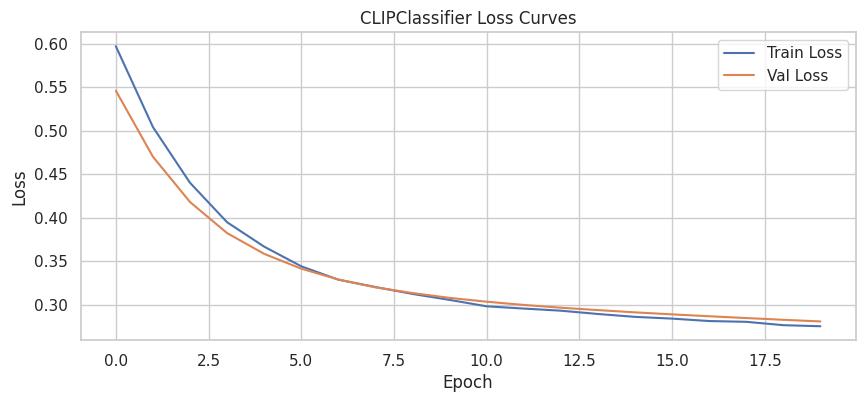

In [ ]:
clip_classifier = CLIPClassifier(clip_model).to(device)
clip_model_path = os.path.join(models_dir, "clip_classifier_best.pth")
clip_classifier, clip_history = train_and_save_model(
    model=clip_classifier,
    model_name="CLIPClassifier",
    save_path=clip_model_path,
    num_epochs=20,
    patience=5
)
plot_training_curves(clip_history, "CLIPClassifier")

### Model Insights: Autoencoder and CLIPClassifier

#### Autoencoder

1. The training and validation loss consistently decreased across all 40 epochs.
2. This shows that the model learned to reconstruct images better over time.
3. There were no sudden jumps or signs of overfitting — the curve was smooth.

However, the reconstruction error dropped slowly after the first 20 epochs, meaning the model kept improving, but only a little at a time. Since this is an unsupervised model, it doesn't give direct class predictions. I would need to set a threshold on the reconstruction loss to detect anomalies (artifacts).  

#### CLIPClassifier

1. The model improved a lot during the first few epochs — validation loss dropped, and micro F1 increased quickly.
2. After that, the F1 score stayed constant (0.90) for the rest of training.
3. Validation loss kept decreasing slowly, but the actual classification performance didn’t change. This could mean the model reached its limit early, possibly because I froze the CLIP backbone and only trained the classifier on top.  

The CLIP-based model gives decent results with minimal training. It was fast and stable, but its performance didn’t improve much after the first few epochs. To go further, I would probably need to fine-tune more layers.

## 5. GradCAM Visualizations

After getting not so low accuracy on EfficientNet model, I wanted to go one step further and understand what the model is actually looking at.

I need to know if the model is focusing on relevant parts of the image (like faces, eyes, hands..), or if it’s relying on unrelated background noise.

To do this, I used GradCAM, a popular method for visualizing class activation maps.

In [ ]:
!pip install numpy==1.26.4 --quiet

In [ ]:
!pip install torchcam timm --quiet

In [ ]:
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import matplotlib.pyplot as plt
import timm
import torch
import torch.nn as nn

Loaded the trained EfficientNet-B0 model using the best checkpoint I saved earlier.

In [ ]:
class EfficientNetClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model('efficientnet_b0', pretrained=False)
        in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.backbone(x)

# Load trained weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EfficientNetClassifier().to(device)
model.load_state_dict(torch.load(
    '/content/drive/MyDrive/Colab Notebooks/artifact_detection_project/models/effnet_b0_best.pth',
    map_location=device
))
model.eval()

EfficientNetClassifier(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (

In [ ]:
from torchcam.methods import GradCAM
cam_extractor = GradCAM(model.backbone, target_layer="conv_head")

In [ ]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.nn.functional import sigmoid
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import os

visual_transforms = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

GradCAM helps visualize which parts of an image were most important for the model's prediction by:

1. Looking at the gradients that flow into the final convolutional layer;
2. Using those gradients to generate a heatmap showing the "attention" of the model;
3. Overlaying this heatmap onto the original image.

- used torchcam and GradCAM to extract activation maps from the last convolutional layer (conv_head) of the network;
- transformed each image in the validation set to match the model’s input size and normalization;
- ran a forward pass through the model to get predictions;
- backpropagated to collect gradients and generate a GradCAM heatmap;
- overlayed the heatmap onto the original image using torchcam.utils overlay_mask;
- saved the visualizations to a folder so I could look at them later and evaluate the results manually.

In [ ]:
def show_gradcam(image_path, filename, save_dir):
    original = Image.open(image_path).convert("RGB")
    input_tensor = visual_transforms(original).unsqueeze(0).to(device)

    # Forward pass
    out = model(input_tensor)
    score = sigmoid(out).item()
    pred_label = 1 if score > 0.5 else 0

    # Backward pass with retain_graph=True
    model.zero_grad()
    out.backward(torch.ones_like(out), retain_graph=True)

    # GradCAM with score
    activation_map = cam_extractor(class_idx=0, scores=out)[0].cpu()

    # Overlay heatmap
    result = overlay_mask(
        to_pil_image(input_tensor.squeeze().cpu()),
        to_pil_image(activation_map, mode='F'),
        alpha=0.5
    )

    # Save result
    save_path = os.path.join(save_dir, f"cam_{filename}_pred{pred_label}_score{score:.2f}.png")
    result.save(save_path)

In [ ]:
gradcam_dir = '/content/drive/MyDrive/Colab Notebooks/artifact_detection_project/gradcam_outputs'
os.makedirs(gradcam_dir, exist_ok=True)

# Generate GradCAMs for all validation images
for idx, row in val_df.iterrows():
    fname = row['filename']
    img_path = os.path.join(image_dir, fname)
    show_gradcam(img_path, filename=fname.split(".")[0], save_dir=gradcam_dir)

## 6. Predictions on Validation Set

I prepared everything needed to generate predictions on the validation set using all of the trained models: EfficientNet, ResNet, ConvNeXt, and the Autoencoder.

Since this notebook runs on Google Colab, and Colab sessions often disconnect or restart, I duplicated some essential code (like model classes, transforms, and Dataset setup) so I can re-run this section independently.

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/artifact_detection_project'
data_dir = os.path.join(base_dir, 'trainee_dataset')
models_dir = os.path.join(base_dir, 'models')
csv_val = os.path.join(base_dir, 'val.csv')
image_dir = os.path.join(data_dir, 'train')

In [ ]:
val_df = pd.read_csv(csv_val)

Prepare DataLoader

In [ ]:
val_tfms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2(),
])

class ArtifactDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_path = os.path.join(self.image_dir, row['filename'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, torch.tensor(row['label'], dtype=torch.float32)

val_loader = DataLoader(ArtifactDataset(val_df, image_dir, transform=val_tfms),
                        batch_size=32, shuffle=False, num_workers=2)

Helper Functions to Get Predictions

In [ ]:
# For classifier models (EfficientNet, ResNet, ConvNeXt, CLIP)
def get_classifier_predictions(model, dataloader, device):
    model.eval()
    all_probs = []  # will store probabilities (via sigmoid)
    all_bin_preds = []  # binary predictions (thresholded at 0.5)
    all_true = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)  # raw logits
            probs = torch.sigmoid(outputs).cpu().numpy()  # probabilities between 0 and 1
            bin_preds = (probs > 0.5).astype(int)
            all_probs.append(probs)
            all_bin_preds.append(bin_preds)
            all_true.append(labels.numpy())
    all_probs = np.concatenate(all_probs, axis=0)
    all_bin_preds = np.concatenate(all_bin_preds, axis=0).flatten()
    all_true = np.concatenate(all_true, axis=0).astype(int).flatten()
    return all_bin_preds, all_true, all_probs

# Lower reconstruction error indicates a "clean" image (label 1) and higher error indicates an "artifact" (label 0).
# We choose the median error over the validation set as a threshold.
def get_autoencoder_predictions(model, dataloader, device, threshold=None):
    model.eval()
    recon_errors = []
    all_true = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            recon = model(images)
            # Compute mean squared error for each sample over all pixels
            errors = ((images - recon)**2).mean(dim=[1,2,3]).cpu().numpy()
            recon_errors.append(errors)
            all_true.append(labels.numpy())
    recon_errors = np.concatenate(recon_errors, axis=0)
    all_true = np.concatenate(all_true, axis=0).astype(int)
    # If no threshold is provided, use the median error as threshold.
    if threshold is None:
        threshold = np.median(recon_errors)
    # For demonstration, assume: if error <= threshold, then prediction = 1 (clean); else 0 (artifact)
    preds = (recon_errors <= threshold).astype(int)
    return preds, all_true, recon_errors, threshold

Define Model Classes and Load Checkpoints

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- EfficientNet ---
class EfficientNetClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model('efficientnet_b0', pretrained=False)
        in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.backbone(x)

efficientnet = EfficientNetClassifier().to(device)
efficientnet_path = os.path.join(models_dir, "effnet_b0_best.pth")
efficientnet.load_state_dict(torch.load(efficientnet_path, map_location=device))

# --- ResNet ---
class ResNetClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model('resnet50', pretrained=False)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.backbone(x)

resnet = ResNetClassifier().to(device)
resnet_path = os.path.join(models_dir, "resnet50_best.pth")
resnet.load_state_dict(torch.load(resnet_path, map_location=device))

# --- ConvNeXt ---
class ConvNeXtClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model('convnext_tiny', pretrained=False, num_classes=1)

    def forward(self, x):
        return self.backbone(x)

convnext = ConvNeXtClassifier().to(device)
convnext_path = os.path.join(models_dir, "convnext_tiny_best.pth")
convnext.load_state_dict(torch.load(convnext_path, map_location=device))

# --- Autoencoder ---
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

autoencoder = Autoencoder().to(device)
ae_path = os.path.join(models_dir, "autoencoder_best.pth")
autoencoder.load_state_dict(torch.load(ae_path, map_location=device))

<All keys matched successfully>

CLIP-based Classifier

In [ ]:
# Install CLIP first
!pip install ftfy regex tqdm --quiet
!pip install git+https://github.com/openai/CLIP.git --quiet

import clip
from PIL import Image
from torchvision import transforms

# For CLIP, we use a separate transform set:
clip_preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.48145466, 0.4578275, 0.40821073),
        std=(0.26862954, 0.26130258, 0.27577711)
    ),
])

# Create a dataset for CLIP using the same CSV and image_dir
class CLIPDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_path = os.path.join(self.image_dir, row['filename'])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(row['label'], dtype=torch.float32)

clip_val_loader = DataLoader(CLIPDataset(val_df, image_dir, clip_preprocess),
                             batch_size=32, shuffle=False, num_workers=2)

class CLIPClassifier(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.clip_model = clip_model
        self.linear = nn.Linear(self.clip_model.visual.output_dim, 1)

    def forward(self, x):
        # Freeze CLIP image encoder during evaluation
        with torch.no_grad():
            features = self.clip_model.encode_image(x)
        features = features.float()
        return self.linear(features)

clip_model, _ = clip.load("ViT-B/32", device=device)
for param in clip_model.parameters():
    param.requires_grad = False
clip_classifier = CLIPClassifier(clip_model).to(device)
clip_path = os.path.join(models_dir, "clip_classifier_best.pth")
clip_classifier.load_state_dict(torch.load(clip_path, map_location=device))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.5 MB/s eta 0:00:00


100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 75.3MiB/s]


<All keys matched successfully>

Generate Predictions for Each Model

For each classifier (EfficientNet, ResNet, ConvNeXt, CLIP), I use the get_classifier_predictions() function.

For the autoencoder, I use reconstruction error and a threshold to classify each image as artifact or clean.

In [ ]:
# For classifier models, we call get_classifier_predictions() on the val_loader.
effnet_preds, true_labels, effnet_probs = get_classifier_predictions(efficientnet, val_loader, device)
resnet_preds, _, resnet_probs = get_classifier_predictions(resnet, val_loader, device)
convnext_preds, _, convnext_probs = get_classifier_predictions(convnext, val_loader, device)
clip_preds, _, clip_probs = get_classifier_predictions(clip_classifier, clip_val_loader, device)

# For the autoencoder, get predictions based on reconstruction error.
ae_preds, true_labels_ae, recon_errors, ae_threshold = get_autoencoder_predictions(autoencoder, val_loader, device)
# Ensure that true labels match (they should be the same)
assert np.all(true_labels == true_labels_ae), "Mismatch in true labels between models!"

First, I averaged the binary predictions of all five models to get the final ensemble prediction.

Then, I created a selective ensemble using only the top 3 performing models (EfficientNet, ResNet, ConvNeXt) to see if removing the weaker ones would help.

Ensemble Predictions by all 5 models

In [ ]:
# For the ensemble, we average the binary predictions of the 5 models.
all_model_preds = {
    "EfficientNet": effnet_preds,
    "ResNet": resnet_preds,
    "ConvNeXt": convnext_preds,
    "Autoencoder": ae_preds,
    "CLIP": clip_preds,
}

# Compute an average over the binary predictions.
ensemble_avg = np.mean(
    np.column_stack(list(all_model_preds.values())),
    axis=1
)
ensemble_preds = (ensemble_avg > 0.5).astype(int)
all_model_preds["Ensemble"] = ensemble_preds

Ensemble Predictions (Selective)

In [ ]:
# Only use the top-performing models:
selected_models = {
    "EfficientNet": effnet_preds,
    "ResNet": resnet_preds,
    "ConvNeXt": convnext_preds,
}
# Compute an average over the binary predictions of these three models.
selective_ensemble_avg = np.mean(
    np.column_stack(list(selected_models.values())),
    axis=1
)
selective_ensemble_preds = (selective_ensemble_avg > 0.5).astype(int)

all_model_preds["Ensemble Selective"] = selective_ensemble_preds

For each model (and each ensemble), I calculated key metrics and displayed them in a sorted table by F1 score.

Compute Metrics

In [ ]:
metrics_data = []
for name, preds in all_model_preds.items():
    acc = accuracy_score(true_labels, preds)
    precision = precision_score(true_labels, preds)
    recall = recall_score(true_labels, preds)
    f1 = f1_score(true_labels, preds)
    auc = roc_auc_score(true_labels, preds)
    metrics_data.append([name, acc, precision, recall, f1, auc])

metrics_df = pd.DataFrame(metrics_data, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"])
metrics_df = metrics_df.sort_values("F1 Score", ascending=False)
print("\nModel Evaluation Summary:\n")
display(metrics_df)


Model Evaluation Summary:



,Model,Accuracy,Precision,Recall,F1 Score,AUC
6,Ensemble Selective,0.966667,0.964286,1.000000,0.981818,0.833333
1,ResNet,0.955556,0.955621,0.996914,0.975831,0.790123
0,EfficientNet,0.955556,0.961078,0.990741,0.975684,0.814815
2,ConvNeXt,0.955556,0.961078,0.990741,0.975684,0.814815
5,Ensemble,0.947222,0.944606,1.000000,0.971514,0.736111
4,CLIP,0.900000,0.900000,1.000000,0.947368,0.500000
3,Autoencoder,0.461111,0.861111,0.478395,0.615079,0.391975


Confusion Matrices

Plotted confusion matrices for every model — to see exactly how many artifacted (label 0) and clean (label 1) images were predicted correctly or incorrectly.

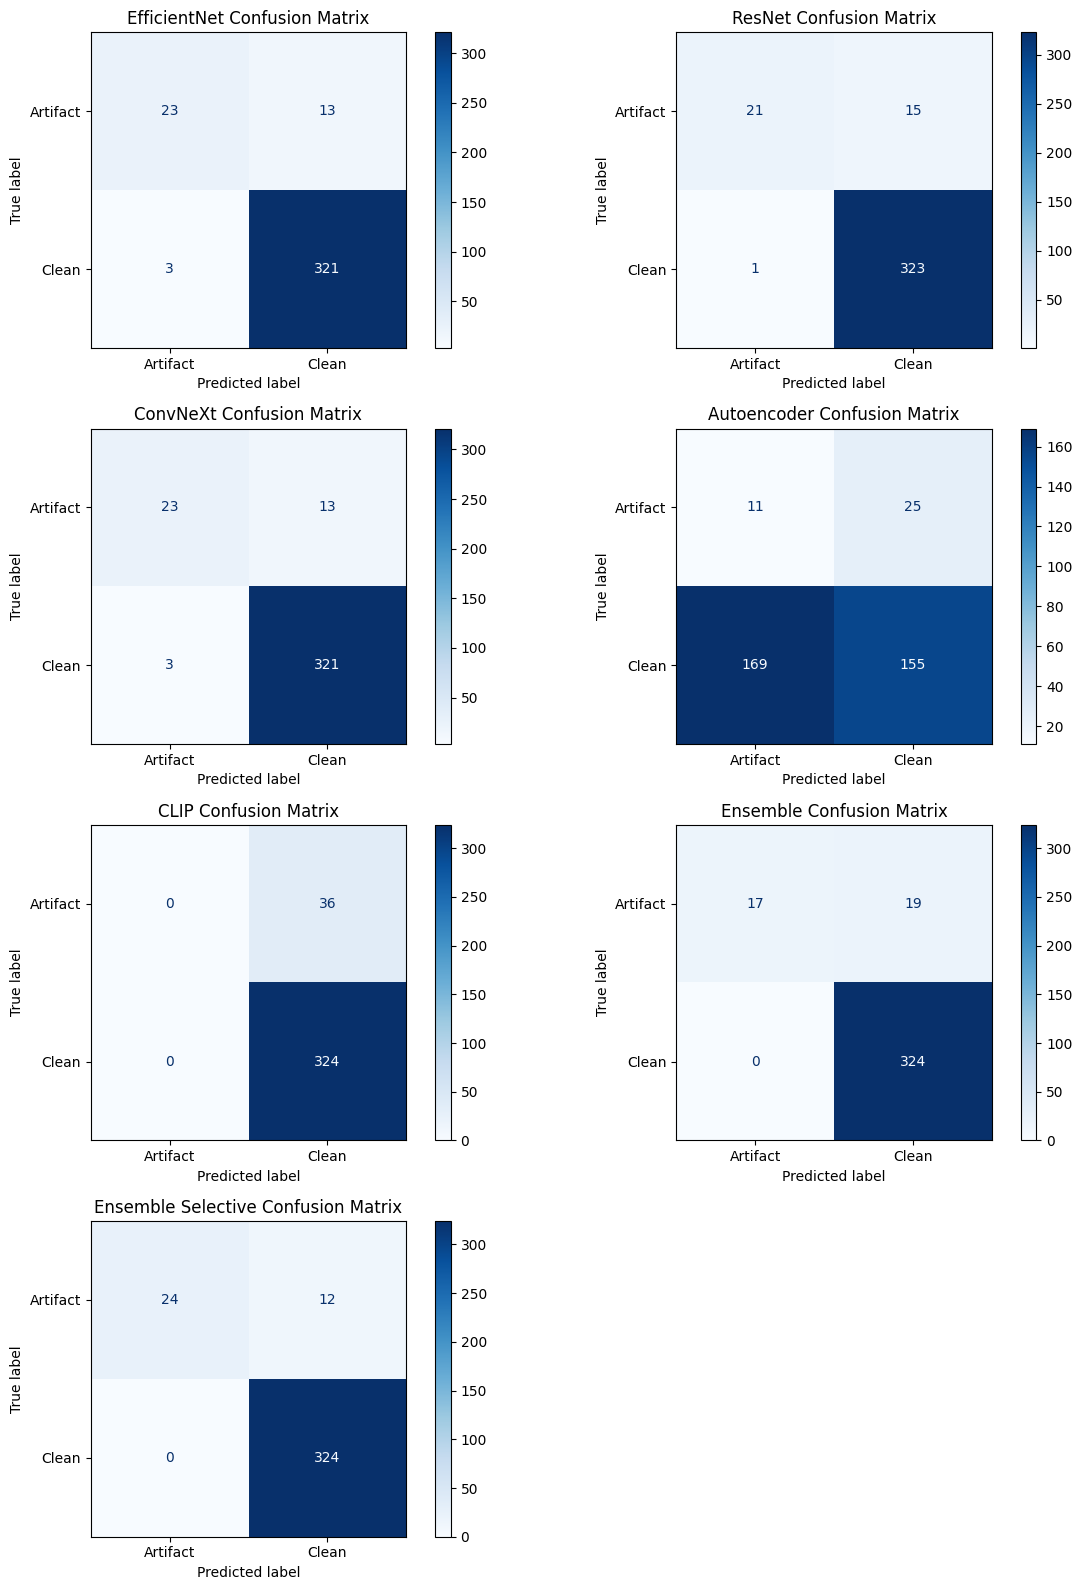

In [ ]:
# Number of models
n_models = len(all_model_preds)

import math

# Choose number of columns (e.g., 2)
n_cols = 2
n_rows = math.ceil(n_models / n_cols)

fig_cm, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.ravel()

for i, (name, preds) in enumerate(all_model_preds.items()):
    cm = confusion_matrix(true_labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Artifact", "Clean"])
    disp.plot(ax=axes[i], cmap="Blues", values_format='d')
    axes[i].set_title(f"{name} Confusion Matrix")

# Hide any unused axes
for j in range(i + 1, len(axes)):
    fig_cm.delaxes(axes[j])

plt.tight_layout()
plt.show()

Plot ROC Curves

Plotted ROC curves — to analyze the trade-off between true positives and false positives and assess model quality across different thresholds.

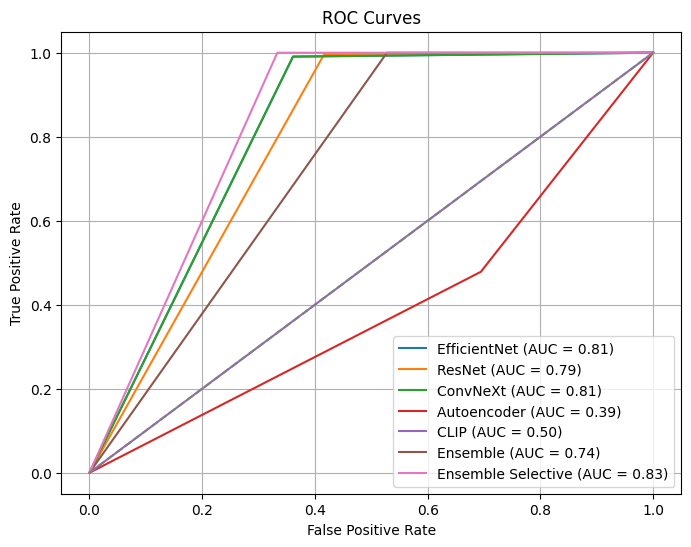

In [ ]:
plt.figure(figsize=(8, 6))
for name, preds in all_model_preds.items():
    fpr, tpr, _ = roc_curve(true_labels, preds)
    auc_score = roc_auc_score(true_labels, preds)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(True)
plt.show()

#### Summary

The dataset is very imbalanced (324 clean vs 36 artifacted), so accuracy alone means little.

1. Selective Ensemble gave the best result — high F1, perfect recall, and decent AUC — but still not perfect precision.
2. EfficientNet, ResNet, ConvNeXt were strong and consistent, but still missed or over-predicted a few.
3. Full Ensemble was worse — adding weak models (CLIP, Autoencoder) hurt performance.
4. CLIP failed —  everything is "clean".
5. Autoencoder failed — low scores across all metrics, not useful in current form.

## 7. Predictions on Test Set

This is the final step, where I tested all trained models on the held-out test set (separate from train and validation).

Here’s what I did:

- parsed the test filenames to extract labels and created a test.csv;
- reated a DataLoader for the test set using the same transforms as validation;
- ran predictions for all models: EfficientNet, ResNet, ConvNeXt, CLIP, and Autoencoder;
- calculated two ensembles: full ensemble using all 5 models, selective ensemble using only the top 3 (EfficientNet, ResNet, ConvNeXt);
- collected classification metrics: Accuracy, Precision, Recall, F1 Score, and AUC;
- plotted confusion matrices to see how each model handled the artifact vs clean class;
- plotted ROC curves to visualize model quality across different thresholds.

This final evaluation shows how well each model generalizes on truly unseen data

In [ ]:
# Define paths for the test dataset; assuming it is structured like the training set.
csv_test = os.path.join(base_dir, 'test.csv')  # This CSV should have the same format as 'train.csv'
# Set the image directory to the 'test' folder
test_image_dir = os.path.join(data_dir, 'test')

In [ ]:
test_files = [f for f in os.listdir(test_image_dir) if f.endswith('.png')]
test_df = pd.DataFrame(test_files, columns=['filename'])
test_df['label'] = test_df['filename'].str.extract(r'_(\d)\.png').astype(int)
test_df.to_csv(csv_test, index=False)

In [ ]:
test_loader = DataLoader(ArtifactDataset(test_df, test_image_dir, transform=val_tfms),
                         batch_size=32, shuffle=False, num_workers=2)

In [ ]:
# For classifier models:
effnet_test_preds, test_true, effnet_test_probs = get_classifier_predictions(efficientnet, test_loader, device)
resnet_test_preds, _, resnet_test_probs = get_classifier_predictions(resnet, test_loader, device)
convnext_test_preds, _, convnext_test_probs = get_classifier_predictions(convnext, test_loader, device)

# For CLIP we use its dedicated test loader (if test CSV is available, we can reuse our CLIPDataset)
clip_test_loader = DataLoader(CLIPDataset(test_df, test_image_dir, clip_preprocess),
                                batch_size=32, shuffle=False, num_workers=2)
clip_test_preds, _, clip_test_probs = get_classifier_predictions(clip_classifier, clip_test_loader, device)

# For the autoencoder:
ae_test_preds, test_true_ae, test_recon_errors, ae_test_threshold = get_autoencoder_predictions(autoencoder, test_loader, device)
assert np.all(test_true == test_true_ae), "Mismatch in test labels between models!"

In [ ]:
# Ensemble using all 5 models:
all_test_model_preds = {
    "EfficientNet": effnet_test_preds,
    "ResNet": resnet_test_preds,
    "ConvNeXt": convnext_test_preds,
    "Autoencoder": ae_test_preds,
    "CLIP": clip_test_preds,
}
ensemble_avg_test = np.mean(np.column_stack(list(all_test_model_preds.values())), axis=1)
ensemble_test_preds = (ensemble_avg_test > 0.5).astype(int)
all_test_model_preds["Ensemble"] = ensemble_test_preds

In [ ]:
# Selective Ensemble (only top performers: EfficientNet, ResNet, ConvNeXt)
selected_test_models = {
    "EfficientNet": effnet_test_preds,
    "ResNet": resnet_test_preds,
    "ConvNeXt": convnext_test_preds,
}
selective_ensemble_avg_test = np.mean(np.column_stack(list(selected_test_models.values())), axis=1)
selective_ensemble_test_preds = (selective_ensemble_avg_test > 0.5).astype(int)
all_test_model_preds["Ensemble Selective"] = selective_ensemble_test_preds

In [ ]:
metrics_data = []
for name, preds in all_test_model_preds.items():
    acc = accuracy_score(test_true, preds)
    precision = precision_score(test_true, preds)
    recall = recall_score(test_true, preds)
    f1 = f1_score(test_true, preds)
    auc = roc_auc_score(test_true, preds)
    metrics_data.append([name, acc, precision, recall, f1, auc])

metrics_df_test = pd.DataFrame(metrics_data, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"])
metrics_df_test = metrics_df_test.sort_values("F1 Score", ascending=False)
print("\nTest Evaluation Summary:\n")
display(metrics_df_test)


Test Evaluation Summary:



,Model,Accuracy,Precision,Recall,F1 Score,AUC
6,Ensemble Selective,0.965,0.962567,1.000000,0.980926,0.825000
1,ResNet,0.960,0.967391,0.988889,0.978022,0.844444
5,Ensemble,0.955,0.952381,1.000000,0.975610,0.775000
2,ConvNeXt,0.955,0.962162,0.988889,0.975342,0.819444
0,EfficientNet,0.950,0.956989,0.988889,0.972678,0.794444
4,CLIP,0.900,0.900000,1.000000,0.947368,0.500000
3,Autoencoder,0.440,0.840000,0.466667,0.600000,0.333333


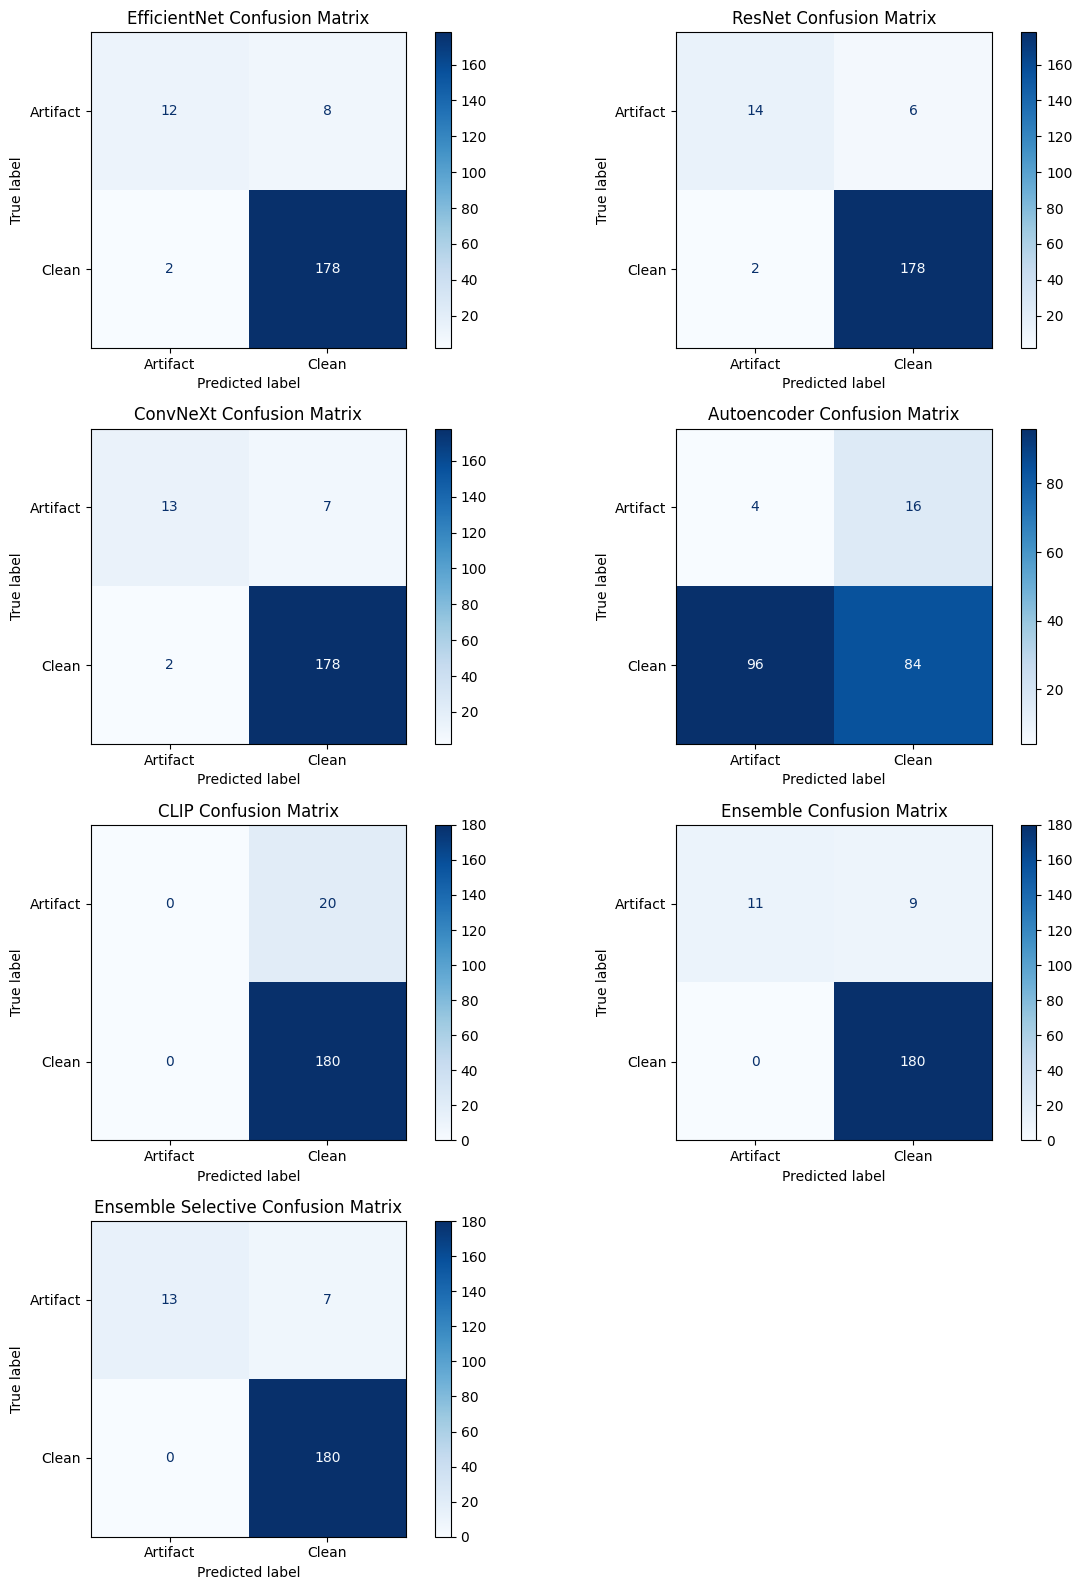

In [ ]:
n_models_test = len(all_test_model_preds)
n_cols = 2
n_rows = math.ceil(n_models_test / n_cols)

fig_cm_test, axes_test = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes_test = axes_test.ravel()

from sklearn.metrics import ConfusionMatrixDisplay
for i, (name, preds) in enumerate(all_test_model_preds.items()):
    cm = confusion_matrix(test_true, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Artifact", "Clean"])
    disp.plot(ax=axes_test[i], cmap="Blues", values_format='d')
    axes_test[i].set_title(f"{name} Confusion Matrix")

# Hide any unused axes if necessary
for j in range(i + 1, len(axes_test)):
    fig_cm_test.delaxes(axes_test[j])
plt.tight_layout()
plt.show()

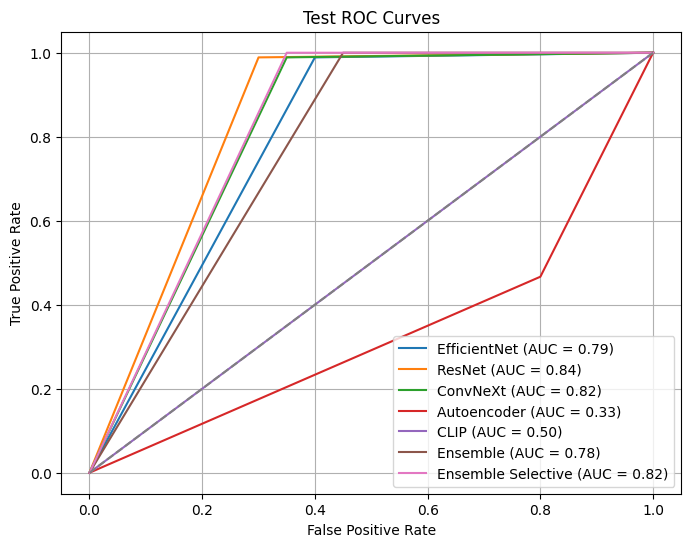

In [ ]:
plt.figure(figsize=(8, 6))
for name, preds in all_test_model_preds.items():
    fpr, tpr, _ = roc_curve(test_true, preds)
    auc_score = roc_auc_score(test_true, preds)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC Curves")
plt.legend()
plt.grid(True)
plt.show()

### Conclusion

The results on the test set aren’t quite satisfying. Out of 20 artifact images, our best method (the selective ensemble (EfficientNet + ResNet + ConvNeXt)) only caught 13 correctly, misclassifying 7 as clean. I suspect the poor performance is largely due to the imbalance in our dataset; we’re dealing with roughly 200 defective images versus about 1600 good ones (a 1:9 ratio). This significant imbalance means that even the best model struggles to capture the subtle signs of defects.

To improve the system, I should have addressed this imbalance earlier: either by oversampling defect samples or using a loss function that adjusts for the class proportions. But beyond just rebalancing, I believe a smarter approach to analyzing faces is necessary.

A better strategy could start with **face detection** (e.g., via MTCNN or MediaPipe) to crop and isolate the face. This removes distractions from the background and focuses on the most important region. I could go further by extracting **facial landmarks** - like eye position, face symmetry, or gaze direction by using tools like Dlib or MediaPipe Face Mesh. These features might help catch subtle issues like missing smth or odd symmetry.

Another idea is to use **face recognition models** like ArcFace or FaceNet as feature extractors. These models I believe generate embeddings that capture facial identity and structure defected images could stand out as outliers. Finally, using a **dual-input strategy** (both full image and face crop) or incorporating **eye gaze tracking** could also improve defect detection where visual cues are more subtle.

#### In short: fixing data imbalance and analyzing facial structure more deeply are likely the keys to getting better results on this kind of problem.

#### Key Issues and Improvements
1. Localized Artifacts: models trained on full-frame images struggled to identify subtle defects.
> Crop or focus on critical regions (faces, hands).

2. Lack of Error Analysis: didn’t analyze misclassified images closely.
> Review or cluster errors to find patterns.

3. Thresholding: autoencoder and ensemble used arbitrary thresholds.
> Use ROC analysis for optimal thresholds per model.

4. Visualization: GradCAM visualizations were not focused on errors.
> Run GradCAM specifically on misclassified cases.

5. Facial Landmarks: ignored structural facial data.
> Extract facial landmarks (using Dlib or MediaPipe) for deeper feature analysis.

## 8. ROI (without the val split)

### 0. Libraries and Setup

In [1]:
!pip install numpy==1.26.4 --quiet
!pip install torchcam timm --quiet

In [2]:
!pip install mediapipe==0.10.5


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch and related libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# GradCAM (torchcam)
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# Face detection and landmarks via MediaPipe
import mediapipe as mp

### 1. Precompute and Cache ROIs

In [35]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Paths
base_dir = '/content/drive/MyDrive/Colab Notebooks/artifact_detection_project'
data_dir = os.path.join(base_dir, 'trainee_dataset')
train_path = os.path.join(data_dir, 'train')
test_path = os.path.join(data_dir, 'test')
train_roi_dir = os.path.join(data_dir, 'train_roi')
test_roi_dir = os.path.join(data_dir, 'test_roi')

# Create ROI directories
os.makedirs(train_roi_dir, exist_ok=True)
os.makedirs(test_roi_dir, exist_ok=True)

# Initialize MediaPipe face detection (using entire face) – model_selection remains 1 (you may experiment with 0)
face_detection = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.7)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
def extract_roi_from_image(image, face_detection):
    """Extract the entire face from an image using face detection.
       Returns the face crop if detected; otherwise returns None."""
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    detection_results = face_detection.process(image_rgb)
    if detection_results.detections:
        detection = detection_results.detections[0]
        bbox = detection.location_data.relative_bounding_box
        h, w, _ = image.shape
        x = int(bbox.xmin * w)
        y = int(bbox.ymin * h)
        box_w = int(bbox.width * w)
        box_h = int(bbox.height * h)
        face_crop = image[y:y+box_h, x:x+box_w]
        return face_crop
    else:
        return None

def precompute_and_cache_rois(input_dir, output_dir, face_detection):
    filenames = [f for f in os.listdir(input_dir) if f.endswith(".png")]
    for filename in tqdm(filenames, desc=f"Processing {os.path.basename(input_dir)}"):
        img_path = os.path.join(input_dir, filename)
        image = cv2.imread(img_path)
        if image is None:
            continue
        roi = extract_roi_from_image(image, face_detection)
        if roi is None:
            # If detection fails, use the resized original image
            roi = cv2.resize(image, (224, 224))
        else:
            roi = cv2.resize(roi, (224, 224))
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, roi)

In [37]:
# Precompute ROIs for train and test using the entire face
precompute_and_cache_rois(train_path, train_roi_dir, face_detection)
precompute_and_cache_rois(test_path, test_roi_dir, face_detection)

Processing test: 100%|██████████| 200/200 [00:15<00:00, 12.78it/s]


### 1. Data Preparation

In [107]:
# Define base directories and CSV paths
models_dir = os.path.join(base_dir, 'models')
csv_train = os.path.join(base_dir, 'train.csv')
csv_val = os.path.join(base_dir, 'val.csv')
csv_test = os.path.join(base_dir, 'test.csv')

# Use cached ROI folders
train_roi_dir = os.path.join(data_dir, 'train_roi')
test_roi_dir  = os.path.join(data_dir, 'test_roi')

# Define paths to image folders
train_path = os.path.join(data_dir, 'train')
test_path = os.path.join(data_dir, 'test')

# Create directories if they don't exist
os.makedirs(data_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

I would have used the splits I created earlier by loading from CSV, but I thought they might not be ideal and that the issue could be there. So I decided to use the test and train folders directly instead.

Total TRAIN images: 1800
Total TEST images: 200
Train class distribution:
 label
1    1620
0     180
Name: count, dtype: int64
Test class distribution:
 label
1    180
0     20
Name: count, dtype: int64


<ipython-input-136-598e12225108>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='label', ax=axes[0], palette='Set2')
<ipython-input-136-598e12225108>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=test_df, x='label', ax=axes[1], palette='Set2')


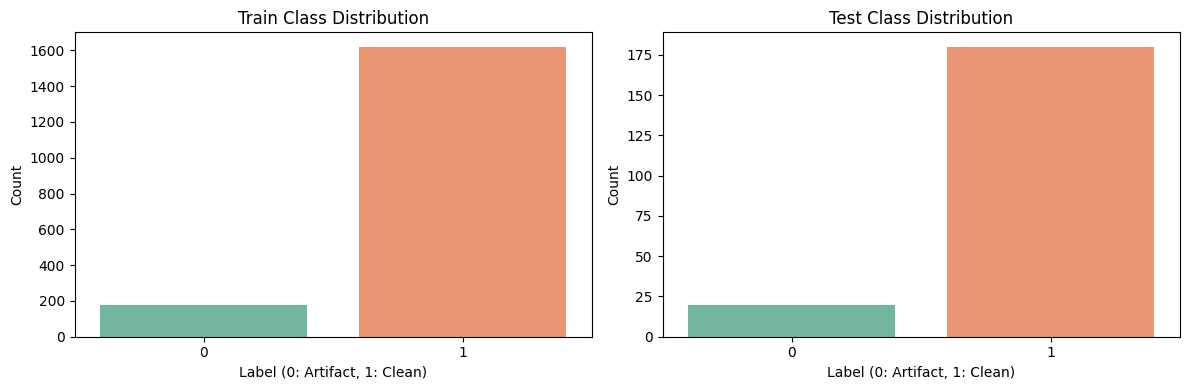

In [136]:
# Get list of train files from train directory
train_files = [f for f in os.listdir(train_path) if f.endswith(".png")]
train_df = pd.DataFrame({'filename': train_files})
train_df['label'] = train_df['filename'].str.extract(r'_(\d)\.png').astype(int)

# Get list of test files from test directory
test_files = [f for f in os.listdir(test_path) if f.endswith(".png")]
test_df = pd.DataFrame({'filename': test_files})
test_df['label'] = test_df['filename'].str.extract(r'_(\d)\.png').astype(int)

# Display total counts
print(f"Total TRAIN images: {len(train_df)}")
print(f"Total TEST images: {len(test_df)}")

# Print value counts
print("Train class distribution:\n", train_df['label'].value_counts())
print("Test class distribution:\n", test_df['label'].value_counts())

# Plot both distributions in one figure
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(data=train_df, x='label', ax=axes[0], palette='Set2')
axes[0].set_title('Train Class Distribution')
axes[0].set_xlabel('Label (0: Artifact, 1: Clean)')
axes[0].set_ylabel('Count')

sns.countplot(data=test_df, x='label', ax=axes[1], palette='Set2')
axes[1].set_title('Test Class Distribution')
axes[1].set_xlabel('Label (0: Artifact, 1: Clean)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Assign DataFrames to be used for training and testing
train_split_df = train_df
val_split_df = test_df

### 2. Define Data Augmentations

In [129]:
# Base transformation for all samples (resizing, flip, brightness/contrast adjustments)
base_tfms = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(p=0.4),
    A.Normalize(),
    ToTensorV2(),
])
# Aggressive augmentation exclusively for artifact samples (with a resize step added)
artifact_tfms = A.Compose([
    A.Rotate(limit=20, p=0.7),
    A.RandomScale(scale_limit=0.2, p=0.7),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.7),
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2(),
])
# Validation transformation
val_tfms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2(),
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


### 3. Dataset for Cached ROI Images

In [130]:
class CachedROIDataset(Dataset):
    """Loads cached ROI images and applies extra augmentation for artifact samples."""
    def __init__(self, df, roi_dir, base_transform=None):
        self.df = df.reset_index(drop=True)
        self.roi_dir = roi_dir
        self.base_transform = base_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_path = os.path.join(self.roi_dir, row['filename'])
        image = cv2.imread(img_path)
        if image is None:
            image = np.zeros((224, 224, 3), dtype=np.uint8)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Conditionally apply aggressive augmentations for artifact samples (label 0)
        if int(row['label']) == 0:
            augmented = artifact_tfms(image=image)
        else:
            augmented = self.base_transform(image=image)
        image = augmented['image']
        # Ensure the image tensor is in float32
        image = image.float()
        label = torch.tensor(row['label'], dtype=torch.float32)
        return image, label

### 4. Create DataLoaders (with Oversampling)


In [131]:
train_dataset = CachedROIDataset(train_split_df, train_roi_dir, base_transform=base_tfms)
val_dataset   = CachedROIDataset(val_split_df, test_roi_dir, base_transform=val_tfms)

train_labels = train_split_df['label'].values.astype(int)
class_counts = np.bincount(train_labels)
weights = np.array([1.0 / class_counts[label] for label in train_labels])
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

### 5. Define Focal Loss

In [132]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss.mean()

### 6. Training Utilities with Learning Rate Scheduler and Unfreezing Layers


In [133]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, labels in tqdm(dataloader, desc="Training Epoch"):
        images, labels = images.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = (torch.sigmoid(outputs).cpu().numpy() > 0.5).astype(int)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds)
    return total_loss / len(dataloader), f1_score(y_true, y_pred, average='micro')

class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.best_state = None

    def step(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_state = model.state_dict()
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

    def restore_best_weights(self, model):
        model.load_state_dict(self.best_state)

def train_and_save_model(model, model_name, save_path, num_epochs=100, patience=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    # Unfreeze all layers
    for param in model.parameters():
        param.requires_grad = True

    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = FocalLoss(alpha=0.25, gamma=2)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    early_stopping = EarlyStopping(patience=patience)
    history = {'train_loss': [], 'val_loss': [], 'val_f1': []}

    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch} ({model_name})")
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_f1 = validate(model, val_loader, criterion, device)
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | F1: {val_f1:.4f}")
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
        scheduler.step()

        if early_stopping.step(val_loss, model):
            print(f"No improvement for {patience} epochs. Early stopping.")
            break

    early_stopping.restore_best_weights(model)
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")
    return model, history

def plot_training_curves(history, model_name):
    plt.figure(figsize=(10, 4))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f"{model_name} Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

### 7. Define Region-Specific CNN Classifier (Using Entire Face)


In [134]:
class EfficientNetClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True)
        in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Linear(in_features, 1)
    def forward(self, x):
        return self.backbone(x)

### 7. Train the Model



Epoch 1 (EfficientNet_ROI)


Training Epoch: 100%|██████████| 57/57 [00:19<00:00,  2.97it/s]


Train Loss: 0.0214 | Val Loss: 0.0065 | F1: 0.9850

Epoch 2 (EfficientNet_ROI)


Training Epoch: 100%|██████████| 57/57 [00:20<00:00,  2.77it/s]


Train Loss: 0.0070 | Val Loss: 0.0045 | F1: 0.9800

Epoch 3 (EfficientNet_ROI)


Training Epoch: 100%|██████████| 57/57 [00:18<00:00,  3.01it/s]


Train Loss: 0.0041 | Val Loss: 0.0039 | F1: 0.9800

Epoch 4 (EfficientNet_ROI)


Training Epoch: 100%|██████████| 57/57 [00:22<00:00,  2.57it/s]


Train Loss: 0.0025 | Val Loss: 0.0036 | F1: 0.9850

Epoch 5 (EfficientNet_ROI)


Training Epoch: 100%|██████████| 57/57 [00:19<00:00,  2.99it/s]


Train Loss: 0.0029 | Val Loss: 0.0030 | F1: 0.9900

Epoch 6 (EfficientNet_ROI)


Training Epoch: 100%|██████████| 57/57 [00:19<00:00,  2.98it/s]


Train Loss: 0.0032 | Val Loss: 0.0025 | F1: 0.9900

Epoch 7 (EfficientNet_ROI)


Training Epoch: 100%|██████████| 57/57 [00:19<00:00,  2.94it/s]


Train Loss: 0.0022 | Val Loss: 0.0052 | F1: 0.9900

Epoch 8 (EfficientNet_ROI)


Training Epoch: 100%|██████████| 57/57 [00:18<00:00,  3.10it/s]


Train Loss: 0.0016 | Val Loss: 0.0039 | F1: 0.9900

Epoch 9 (EfficientNet_ROI)


Training Epoch: 100%|██████████| 57/57 [00:17<00:00,  3.25it/s]


Train Loss: 0.0016 | Val Loss: 0.0044 | F1: 0.9850

Epoch 10 (EfficientNet_ROI)


Training Epoch: 100%|██████████| 57/57 [00:16<00:00,  3.46it/s]


Train Loss: 0.0009 | Val Loss: 0.0051 | F1: 0.9850

Epoch 11 (EfficientNet_ROI)


Training Epoch: 100%|██████████| 57/57 [00:16<00:00,  3.46it/s]


Train Loss: 0.0005 | Val Loss: 0.0040 | F1: 0.9900

Epoch 12 (EfficientNet_ROI)


Training Epoch: 100%|██████████| 57/57 [00:17<00:00,  3.23it/s]


Train Loss: 0.0005 | Val Loss: 0.0043 | F1: 0.9900

Epoch 13 (EfficientNet_ROI)


Training Epoch: 100%|██████████| 57/57 [00:16<00:00,  3.40it/s]


Train Loss: 0.0003 | Val Loss: 0.0046 | F1: 0.9900

Epoch 14 (EfficientNet_ROI)


Training Epoch: 100%|██████████| 57/57 [00:17<00:00,  3.34it/s]


Train Loss: 0.0003 | Val Loss: 0.0051 | F1: 0.9900
No improvement for 8 epochs. Early stopping.
Model saved to /content/drive/MyDrive/Colab Notebooks/artifact_detection_project/models/effnet_b0_roi_best.pth


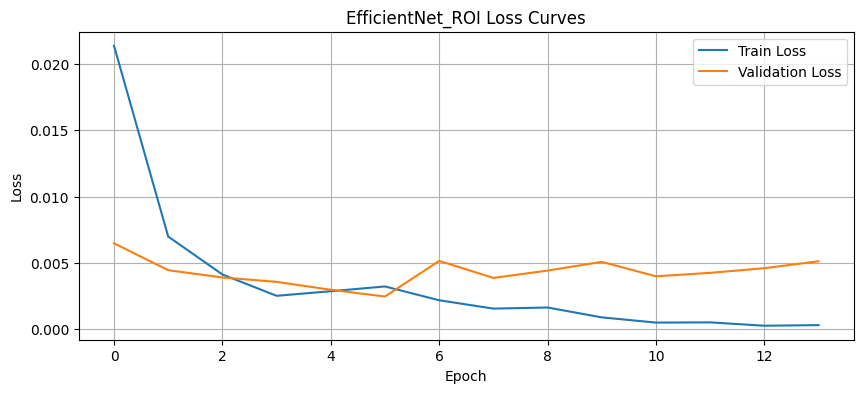

In [143]:
model = EfficientNetClassifier()
model_save_path = os.path.join(models_dir, "effnet_b0_roi_best.pth")
model, history = train_and_save_model(model, "EfficientNet_ROI", model_save_path, num_epochs=50, patience=8)
plot_training_curves(history, "EfficientNet_ROI")

### 9. Evaluation with ROC Analysis, Metrics Table, and Confusion Matrices


In [144]:
def get_classifier_predictions(model, dataloader, device):
    model.eval()
    all_probs = []
    all_bin_preds = []
    all_true = []
    for images, labels in dataloader:
        images = images.to(device)
        images.requires_grad_()  # enable gradients for hooks if needed
        outputs = model(images)
        probs = torch.sigmoid(outputs).detach().cpu().numpy()  # detach after computing outputs
        bin_preds = (probs > 0.5).astype(int)
        all_probs.append(probs)
        all_bin_preds.append(bin_preds)
        all_true.append(labels.numpy())
    all_probs = np.concatenate(all_probs, axis=0)
    all_bin_preds = np.concatenate(all_bin_preds, axis=0).flatten()
    all_true = np.concatenate(all_true, axis=0).astype(int).flatten()
    return all_bin_preds, all_true, all_probs

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
preds, test_true, probs = get_classifier_predictions(model, val_loader, device)

acc = accuracy_score(test_true, preds)
prec = precision_score(test_true, preds)
rec = recall_score(test_true, preds)
f1 = f1_score(test_true, preds)
auc = roc_auc_score(test_true, probs)
print(f"Validation Metrics: Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

Validation Metrics: Accuracy: 0.9900 | Precision: 0.9944 | Recall: 0.9944 | F1: 0.9944 | AUC: 0.9953


In [145]:
# Create a metrics table
all_test_model_preds = {"EfficientNet": preds}
metrics_data = []
for name, model_preds in all_test_model_preds.items():
    a = accuracy_score(test_true, model_preds)
    p = precision_score(test_true, model_preds)
    r = recall_score(test_true, model_preds)
    f = f1_score(test_true, model_preds)
    auc_score = roc_auc_score(test_true, model_preds)  # using binary predictions here
    metrics_data.append([name, a, p, r, f, auc_score])
metrics_df_test = pd.DataFrame(metrics_data, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"])
metrics_df_test = metrics_df_test.sort_values("F1 Score", ascending=False)
print("\nValidation Evaluation Summary:\n")
display(metrics_df_test)


Validation Evaluation Summary:



,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,EfficientNet,0.99,0.994444,0.994444,0.994444,0.972222


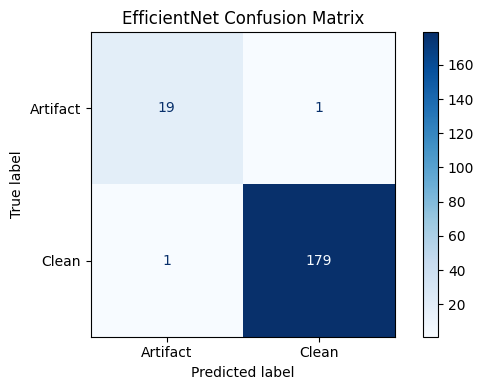

In [146]:
# Plot confusion matrix
import math
n_models_test = len(all_test_model_preds)
n_cols = 2
n_rows = math.ceil(n_models_test / n_cols)
fig_cm_test, axes_test = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes_test = axes_test.ravel()
for i, (name, model_preds) in enumerate(all_test_model_preds.items()):
    cm = confusion_matrix(test_true, model_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Artifact", "Clean"])
    disp.plot(ax=axes_test[i], cmap="Blues", values_format='d')
    axes_test[i].set_title(f"{name} Confusion Matrix")
for j in range(i + 1, len(axes_test)):
    fig_cm_test.delaxes(axes_test[j])
plt.tight_layout()
plt.show()

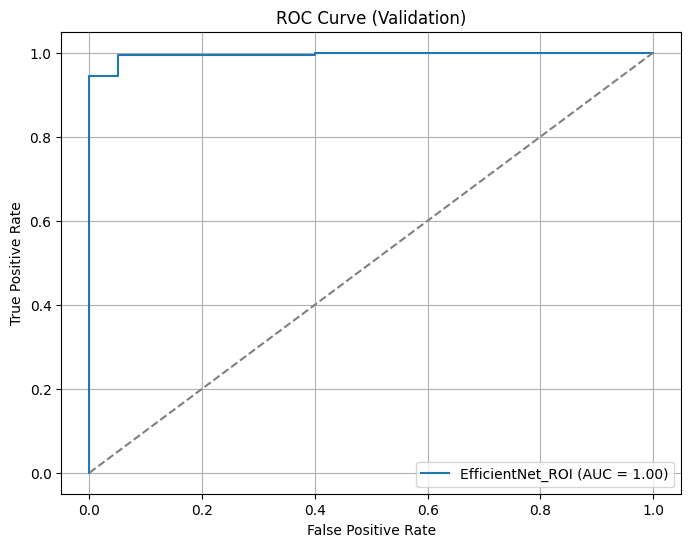

In [147]:
# Plot ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(test_true, probs)
auc_score = roc_auc_score(test_true, probs)
plt.plot(fpr, tpr, label=f"EfficientNet_ROI (AUC = {auc_score:.2f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation)")
plt.legend()
plt.grid(True)
plt.show()

### 9. GradCAM Visualizations


In [148]:
# For GradCAM, use the final conv layer from the backbone
cam_extractor = GradCAM(model.backbone, target_layer="conv_head")
visual_transforms = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def show_gradcam(image_path, filename, save_dir):
    from PIL import Image
    original = Image.open(image_path).convert("RGB")
    input_tensor = visual_transforms(original).unsqueeze(0).to(device)

    output = model(input_tensor)
    score = torch.sigmoid(output).item()
    pred_label = 1 if score > 0.5 else 0

    model.zero_grad()
    output.backward(torch.ones_like(output), retain_graph=True)
    activation_map = cam_extractor(class_idx=0, scores=output)[0].cpu()

    result = overlay_mask(to_pil_image(input_tensor.squeeze().cpu()),
                          to_pil_image(activation_map, mode='F'),
                          alpha=0.5)
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"cam_{filename}_pred{pred_label}_score{score:.2f}.png")
    result.save(save_path)

gradcam_dir = os.path.join(base_dir, "gradcam_outputs_roi")
os.makedirs(gradcam_dir, exist_ok=True)

In [149]:
# Generate GradCAM visualizations for several validation images from the original cached ROI folder
for idx, row in val_split_df.iterrows():
    fname = row['filename']
    img_path = os.path.join(test_roi_dir, fname)
    base_name = os.path.splitext(fname)[0]
    show_gradcam(img_path, base_name, gradcam_dir)

### Summary

First of all, the performance significantly improved -- even compared to the earlier ensemble model.

This boost may be attributed to the use of ROI-based preprocessing in the current setup or the fact that I trained directly on the full training set without splitting it into a separate validation set. Ideally, I should have isolated the factors contributing to this improvement through controlled experimentation, but due to the approaching deadline, I prioritized moving forward.